In [1]:
import datetime
import pandas as pd
import numpy as np

In [2]:
# Convert string to datetime object.
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

# Convert date column to datetime and set as index.
def prepare_datetime_index(df, date_column='Date'):
    df = df.copy()
    df[date_column] = df[date_column].apply(str_to_datetime)
    df.set_index(date_column, inplace=True)
    return df

In [3]:
"""
    Fill missing pollutant values using forward fill strategy.
    If no previous values exist, use EPA bottom level values as defaults.
    """
def fill_pollutant_values(df):
    
    df = df.copy()
    
    # First apply forward fill to all columns
    df = df.fillna(method='ffill')
    
    # Define EPA bottom level values for any remaining missing values
    pollutant_defaults = {
        'co': 4.4,
        'no2': 53,
        'o3': 0.054,
        'pm10': 54,
        'pm25': 12,
        'so2': 35
    }
    
    # Fill remaining missing pollutant values with EPA defaults
    for pollutant, default_value in pollutant_defaults.items():
        if pollutant in df.columns:
            df[pollutant] = df[pollutant].fillna(default_value)
    
    # Fill any remaining missing values in environmental columns with forward fill
    # followed by backward fill for the first records
    env_columns = ['humidity', 'pressure', 'temperature', 'wind-speed']
    existing_env_columns = [col for col in env_columns if col in df.columns]
    
    if existing_env_columns:
        df[existing_env_columns] = df[existing_env_columns].fillna(method='ffill').fillna(method='bfill')
        
        # If any values are still missing, fill with column mean
        for col in existing_env_columns:
            if df[col].isnull().any():
                df[col] = df[col].fillna(df[col].mean())
    
    return df

In [4]:
"""Impute missing dates in the time series."""
def impute_missing_dates(df, method='ffill'):
    df = df.copy()
    idx = pd.date_range(df.index.min(), df.index.max())
    df = df.reindex(idx)
    
    if method == 'ffill':
        df = df.fillna(method='ffill')
    elif method == 'bfill':
        df = df.fillna(method='bfill')
    else:
        df = df.fillna(method='ffill').fillna(method='bfill')
    
    return df

In [5]:
"""Remove duplicate rows from the dataframe."""
def remove_duplicates(df):
    df = df.copy()
    initial_shape = df.shape
    df = df.drop_duplicates()
    final_shape = df.shape
    
    if initial_shape != final_shape:
        print(f"Removed {initial_shape[0] - final_shape[0]} duplicate rows")
        print(f"Shape before: {initial_shape}, Shape after: {final_shape}")
    
    return df

# **3.3 - Air Quality Index count**

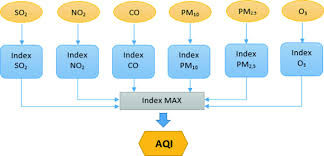

Reference:Dedovic, M. M., Avdaković, S., Mujezinović, A., & Dautbasic, N. (2020). The hybrid EMD-SARIMA model for Air Quality Index Prediction, case of Canton Sarajevo. In Lecture notes in networks and systems (pp. 139–150). https://doi.org/10.1007/978-3-030-54765-3_9

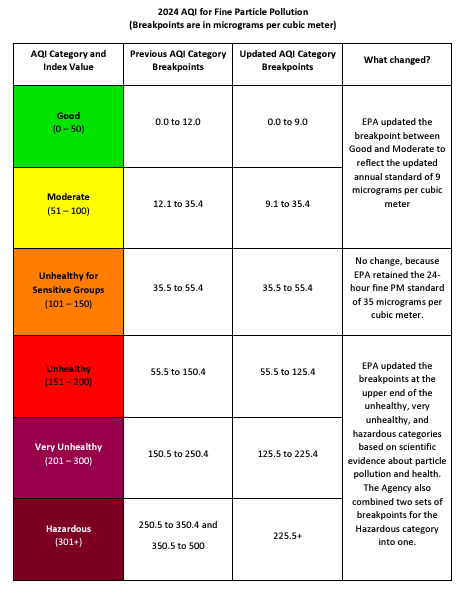

More Info: https://www.epa.gov/system/files/documents/2024-02/pm-naaqs-air-quality-index-fact-sheet.pdf

In [6]:
 """Calculate Air Quality Index."""
def calculate_aqi(data, subindex_columns):
    data = data.copy()
    
    # Count non-zero sub-indices for each row
    data["Checks"] = data[subindex_columns].gt(0).sum(axis=1)
    
    # Calculate AQI as the maximum of all sub-indices
    data["AQI"] = data[subindex_columns].max(axis=1)
    
    # Apply constraints
    data.loc[
        (data["pm25"] == 0) & 
        (data["pm10"] == 0), 
        "AQI"
    ] = 0
    
    data.loc[data["Checks"] < 3, "AQI"] = 0
    
    # Round AQI to the nearest integer
    data["AQI"] = data["AQI"].round()
    
    return data

In [7]:
def process_air_quality_data(df, date_column='Date', subindex_columns=None):
    """Complete pipeline for processing air quality data."""
    # Set default subindex columns if none provided
    if subindex_columns is None:
        subindex_columns = [
           'co', 'no2', 'o3', 'pm10', 'pm25', 'so2'
        ]
    
    # Apply all preprocessing steps
    df = prepare_datetime_index(df, date_column)
    df = fill_pollutant_values(df)
    df = impute_missing_dates(df)
    df = remove_duplicates(df)
    df = calculate_aqi(df, subindex_columns)
    
    return df